## Basic Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
import random
import numpy as np

## SEED setup for Reproducibility and deciding device

In [2]:
SEED = 1

# Apple metal or Nvidia CUDA
use_cuda = torch.cuda.is_available()
use_mps = torch.mps.is_available()

# seed for repeatablility:

# for all devices
torch.manual_seed(SEED)

# for specific acc
if use_cuda:
    print(f"Use CUDA?:{use_cuda}")
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif use_mps:
    print(f"Use MPS?: {use_mps}")
    torch.mps.manual_seed(SEED)
else:
    print("Using CPU")

random.seed(SEED)
np.random.seed(SEED)


if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Use MPS?: True


## Transforms, datasets and dataloaders

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

use_cuda = False
use_mps = False

dataloader_args = dict(shuffle=True,
                       batch_size=128,
                       num_workers=0,
                       pin_memory=True) \
                                        if use_cuda or use_mps else \
                    dict(shuffle=True,
                         batch_size=128)


train_loader = torch.utils.data.DataLoader(train,
                                           **dataloader_args)
test_loader = torch.utils.data.DataLoader(test,
                                          **dataloader_args)


## Network

### Network 2

```Target```: Make model more regularised
- lets add dropout to all the layers

 
```Results```:
- Parameters: 6922
- Best Training Accuracy: 98.22
- Best Test Accuracy: 98.65

```Analysis```: Model is not overfitting anymore but not reaching desired accuracy of 99.4 due to low capacity. 


In [4]:
dropout_p = 0.1

class MyNetwork2(nn.Module):
    def __init__(self):
        super().__init__()

        #INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3), #inch=1, outch=8, size=26, rf=3, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
    
        #CONV BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(8,8, 3), #inch=8, outch=16, size=24, rf=5, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(8,8, 3), #inch=16, inout=32, size=22, rf=7, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(8,16, 3), #inch=16, inout=32, size=22, rf=7, j=1
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # TRANSITION BLOCK
        #POOL LAYER
        self.convblock5 = nn.Sequential(
            nn.Conv2d(16,8,3), #inch32, outch=8, size=20, rf=9, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
    
        #CONV BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(8,8,3), #inch=8, outch=16, size=18, rf=11, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(8,16,3), #inch=16, outch=32, size=16, rf=13, j=1
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(16,10,3), #inch=32, outch=10, size=14, rf=15, j=1
            nn.ReLU()
        )
        #LINEAR LAYER
        # self.fc_layer = nn.Linear(10*14*14, 10)
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        # BLOCK 1
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        # TRANSITION
        x = self.convblock5(x)
        x = self.dropout(x)
        # BLOCK 2
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.dropout(x)
        # OUTPUT
        x = self.convblock8(x)
        # GAP
        x = self.gap(x)
        # here the shape of x will be (batch_size,10,14,14), before passing let's reshape it to (batch_size, 10*14*14)
        x = x.view(x.size(0),-1)
        
        return F.log_softmax(x, dim=1)

### Model summary

In [5]:
# !pip install torchsummary
model_2 = MyNetwork2()

In [6]:
from torchsummary import summary

summary(model_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             584
      BatchNorm2d-10            [-1, 8, 22, 22]              16
             ReLU-11            [-1, 8, 22, 22]               0
          Dropout-12            [-1, 8, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           1,168
      BatchNorm2d-14           [-1, 16,

## Train and Test loops

In [7]:
from tqdm import tqdm

# define metrics to calc

train_losses = []
train_acc = []

test_losses = []
test_acc = []


def train(model, device, train_loader, optimizer):
    # set model to train mode
    model.train()

    # tqdm iterator
    pbar = tqdm(train_loader)

    # correct and processed vars
    correct = 0
    processed = 0

    # loop on batches of data
    for batch_idx, (data,target) in enumerate(pbar):
        #send data, targte to training device
        data, target = data.to(device), target.to(device)

        # Initialize grad to zero for the fresh batch grad accumuation
        optimizer.zero_grad()

        # pred with model
        y_pred = model(data)

        # calc loss
        batch_loss = F.nll_loss(y_pred, target)
        train_losses.append(batch_loss)

        # backprop loss to calc and acc grad w.r.t loss of batch
        batch_loss.backward()
        
        # update weights as per losses seen in this batch
        optimizer.step()

        # calculate correct pred count and acc for batch
        pred_labels = y_pred.argmax(dim=1, keepdim=True)
        correct_count_batch = pred_labels.eq(target.view_as(pred_labels)).sum().item()

        # update total correct and total processed so far
        correct+= correct_count_batch
        processed+= len(data)

        # set pbar desc
        pbar.set_description(desc=f'batch Loss = {batch_loss.item()} batch_id = {batch_idx} accuracy = {100*correct/processed:.02f}'
                            )
        #append train acc
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    # set model to eval mode
    model.eval()

    # define var to calc correct and processed
    correct = 0
    processed = 0
    test_loss = 0 # seeing loss as the code runs has no value for test

    # set a no grad context
    with torch.no_grad():
        for data,target in test_loader:
            #send data, target to device
            data, target = data.to(device), target.to(device)
    
            # do pred
            y_pred = model(data)
    
            #calc loss for batch as summed and update total test loss
            batch_loss = F.nll_loss(y_pred, target, reduction='sum').item()
            test_loss+= batch_loss
            # collect loss
            test_losses.append(batch_loss)
    
            # count correct
            pred_labels = y_pred.argmax(dim=1, keepdim=True)
            correct_batch = pred_labels.eq(target.view_as(pred_labels)).sum().item()
    
            #update correct
            correct+= correct_batch
            processed+= len(data)

    # avg loss on test makes more sense to avg it
    test_loss/= processed
    # collect avg losses
    test_losses.append(test_loss)

    print(f'\n Test set avg loss: {test_loss:.4f} \
                Accuracy: {correct}/{processed}, {100*correct/processed:.2f}'
         )

    test_acc.append(100*correct/processed)

    return test_loss, round(100*correct/processed, 1)
        
    

## Train for n Epochs

In [8]:
# train without scheduler

# initialize model on device
model = model_2.to(device)

# initialize optimizer with model params and lr
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set total epochs
EPOCHS = 14

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)


EPOCH: 0



atch Loss = 0.3118012845516205 batch_id = 468 accuracy = 76.20: 100%|██| 469/469 [00:12<00:00, 36.25it/s]


 Test set avg loss: 0.1970                 Accuracy: 9512/10000, 95.12
EPOCH: 1



atch Loss = 0.10883317142724991 batch_id = 468 accuracy = 94.58: 100%|█| 469/469 [00:11<00:00, 39.24it/s]


 Test set avg loss: 0.1182                 Accuracy: 9643/10000, 96.43
EPOCH: 2



atch Loss = 0.1312245875597 batch_id = 468 accuracy = 96.09: 100%|█████| 469/469 [00:09<00:00, 49.40it/s]


 Test set avg loss: 0.0773                 Accuracy: 9770/10000, 97.70
EPOCH: 3



atch Loss = 0.09325295686721802 batch_id = 468 accuracy = 96.72: 100%|█| 469/469 [00:09<00:00, 50.06it/s]


 Test set avg loss: 0.0663                 Accuracy: 9787/10000, 97.87
EPOCH: 4



atch Loss = 0.20824842154979706 batch_id = 468 accuracy = 97.16: 100%|█| 469/469 [00:09<00:00, 47.18it/s]


 Test set avg loss: 0.0600                 Accuracy: 9810/10000, 98.10
EPOCH: 5



atch Loss = 0.03413282334804535 batch_id = 468 accuracy = 97.46: 100%|█| 469/469 [00:10<00:00, 46.42it/s]


 Test set avg loss: 0.0567                 Accuracy: 9812/10000, 98.12
EPOCH: 6



atch Loss = 0.0795411467552185 batch_id = 468 accuracy = 97.68: 100%|██| 469/469 [00:09<00:00, 47.67it/s]


 Test set avg loss: 0.0550                 Accuracy: 9827/10000, 98.27
EPOCH: 7



atch Loss = 0.06628301739692688 batch_id = 468 accuracy = 97.74: 100%|█| 469/469 [00:09<00:00, 47.29it/s]


 Test set avg loss: 0.0461                 Accuracy: 9855/10000, 98.55
EPOCH: 8



atch Loss = 0.07118239253759384 batch_id = 468 accuracy = 97.98: 100%|█| 469/469 [00:09<00:00, 47.49it/s]


 Test set avg loss: 0.0423                 Accuracy: 9867/10000, 98.67
EPOCH: 9



atch Loss = 0.043160200119018555 batch_id = 468 accuracy = 98.02: 100%|█| 469/469 [00:09<00:00, 50.21it/s


 Test set avg loss: 0.0449                 Accuracy: 9866/10000, 98.66
EPOCH: 10



atch Loss = 0.021357497200369835 batch_id = 468 accuracy = 98.11: 100%|█| 469/469 [00:09<00:00, 49.58it/s


 Test set avg loss: 0.0407                 Accuracy: 9861/10000, 98.61
EPOCH: 11



atch Loss = 0.03757050633430481 batch_id = 468 accuracy = 98.12: 100%|█| 469/469 [00:09<00:00, 50.48it/s]


 Test set avg loss: 0.0497                 Accuracy: 9844/10000, 98.44
EPOCH: 12



atch Loss = 0.03666418418288231 batch_id = 468 accuracy = 98.25: 100%|█| 469/469 [00:09<00:00, 51.17it/s]


 Test set avg loss: 0.0404                 Accuracy: 9874/10000, 98.74
EPOCH: 13



atch Loss = 0.012992494739592075 batch_id = 468 accuracy = 98.22: 100%|█| 469/469 [00:09<00:00, 50.37it/s


 Test set avg loss: 0.0413                 Accuracy: 9865/10000, 98.65


## Further visualization to decide on Augmentation

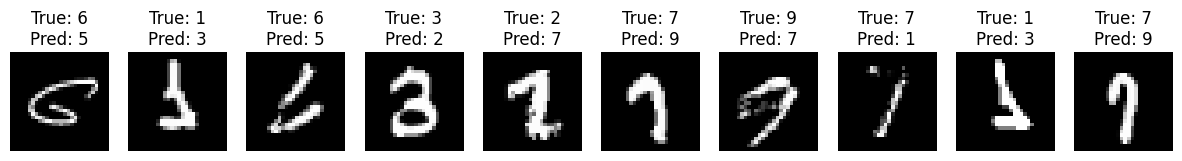

In [9]:
import matplotlib.pyplot as plt

def visualize_mistakes(model, device, test_loader):
    # Set the model to evaluation mode
    model.eval()
    mistakes = []

    with torch.no_grad():
        for data, target in test_loader:
            # Send data to the specified device
            data, target = data.to(device), target.to(device)

            # Get predictions from the model
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            
            # Identify misclassified examples
            misclassified = pred.ne(target.view_as(pred))  # Boolean mask for misclassified samples
            
            for idx in range(data.size(0)):
                if misclassified[idx]:  # If the sample is misclassified
                    mistakes.append({
                        "image": data[idx].cpu(),       # Detach the image tensor
                        "true_label": target[idx].item(),
                        "pred_label": pred[idx].item()
                    })
    
    # Visualize a few misclassified images
    num_mistakes = min(len(mistakes), 10)  # Show up to 10 misclassified images
    fig, axes = plt.subplots(1, num_mistakes, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        mistake = mistakes[i]
        image = mistake["image"].squeeze(0)  # Remove the channel dimension for grayscale images
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        ax.set_title(f"True: {mistake['true_label']}\nPred: {mistake['pred_label']}")
    
    plt.show()
    return mistakes

# After testing, visualize mistakes
mistakes = visualize_mistakes(model, device, test_loader)

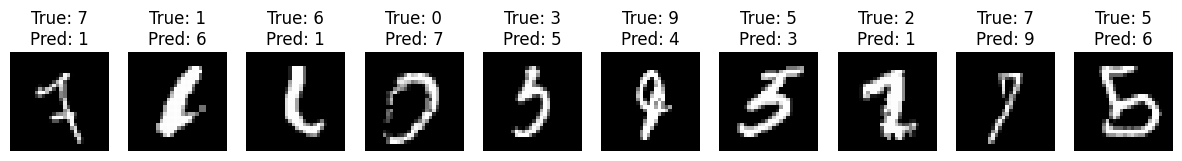

In [24]:
import matplotlib.pyplot as plt

def visualize_mistakes(model, device, test_loader):
    # Set the model to evaluation mode
    model.eval()
    mistakes = []

    with torch.no_grad():
        for data, target in test_loader:
            # Send data to the specified device
            data, target = data.to(device), target.to(device)

            # Get predictions from the model
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            
            # Identify misclassified examples
            misclassified = pred.ne(target.view_as(pred))  # Boolean mask for misclassified samples
            
            for idx in range(data.size(0)):
                if misclassified[idx]:  # If the sample is misclassified
                    mistakes.append({
                        "image": data[idx].cpu(),       # Detach the image tensor
                        "true_label": target[idx].item(),
                        "pred_label": pred[idx].item()
                    })
    
    # Visualize a few misclassified images
    num_mistakes = min(len(mistakes), 10)  # Show up to 10 misclassified images
    fig, axes = plt.subplots(1, num_mistakes, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        mistake = mistakes[i]
        image = mistake["image"].squeeze(0)  # Remove the channel dimension for grayscale images
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        ax.set_title(f"True: {mistake['true_label']}\nPred: {mistake['pred_label']}")
    
    plt.show()
    return mistakes

# After testing, visualize mistakes
mistakes = visualize_mistakes(model, device, test_loader)

In [11]:
mistakes_true_pred_pairs = [(m.get("true_label"),m.get("pred_label")) for m in mistakes]

In [12]:
set([x[0] for x in mistakes_true_pred_pairs])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [13]:
def get_freq(mistakes_list):
    freq_dict = {}
    for md in mistakes_list:
        if md in freq_dict:
            freq_dict[md]+=1
        else:
            freq_dict[md]=1
    return freq_dict

        
freq_dict = get_freq([x[0] for x in mistakes_true_pred_pairs])
freq_dict

{6: 16, 1: 8, 3: 14, 2: 6, 7: 25, 9: 18, 5: 8, 8: 27, 4: 9, 0: 4}